In [6]:
import pandas as pd
import glob

# Removes pandas warning on latest version about using iloc
pd.options.mode.chained_assignment = None 

# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [7]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

---
### Assumption :

- For the daily average new cases per month we decided to select the "new cases confirmed" (or +/- similar) for the three different countries.
- For the daily average of deaths per month we chose to select the "new deaths registered" (or +/- similar) for the three different countries.
- In both cases, we pay attention only to the "confirmed" data.

### How we did it : 

1. Create a new column containing the name of the country in the dataframe of the corresponding country, then join all three dataframes. To avoid complications in further work, we aggregated the different columns that represented the dates into a single one.
2. Guinea : no specific assumption have to be made as the data we process seem to be without ambiguity.
3. Liberia : here we have some ambiguity. For the data concerning the new cases, the daily entries are not consistent among all the sheets. We just recompute it based on the cumulative entries of the new cases, as they seem to be more reliable.
4. Sierra Leone : here we have a similar case to Liberia; for the data concerning the daily new deaths, the entries are written in a cumulative manner, so we will proceed in the exact same way as for the Liberia case, in order to retrieve the daily new deaths.

---
## 1.

In [8]:
path = "Data/ebola"
countries = [("Guinea","guinea_data"), ("Liberia","liberia_data"), ("Sierra Leone","sl_data")]

data = pd.DataFrame()

# for each country dataframe, concatenate all the sheets and add a new column with the corresponding country
for country in countries:
    allFiles = glob.glob(path + "/" + country[1] + "/" + "/*csv")
    data_per_country = pd.concat((pd.read_csv(file) for file in allFiles), axis=0)
    data_per_country['Country'] = country[0]
    data = pd.concat([data, data_per_country])

# merge columns 'Date' and 'date'
data['Date'] = pd.concat([data['Date'].dropna(), data['date'].dropna()])
data = data.drop('date', axis=1)
data['Date'] = pd.to_datetime(data['Date'])

---
## 2.

In [9]:
# Guinea

# basic formating of the data, to be more readable for a human
data_cleaned_guinea = data.query('Country == "Guinea"').dropna(axis=1, how='all').set_index(['Date', 'Description'])['Totals']
data_cleaned_guinea = pd.pivot_table(data_cleaned_guinea.reset_index(), values='Totals', index='Date', columns='Description', aggfunc='sum')

# select the two columns for which we are interested
data_cleaned_guinea = data_cleaned_guinea[['New cases of confirmed', 'New deaths registered']].apply(pd.to_numeric, errors='coerce')

# group by month computing the mean
data_cleaned_guinea = data_cleaned_guinea.groupby(data_cleaned_guinea.index.month).mean()

# display the values in a sexy manner
data_cleaned_guinea.rename_axis({'New cases of confirmed': 'New cases (mean)', 'New deaths registered': 'Deaths (mean)'}, axis='columns', inplace=True)
data_cleaned_guinea.index.names = ['Month']
data_cleaned_guinea.columns.name = ''
data_cleaned_guinea

,New cases (mean),Deaths (mean)
Month,,
8,12.4,3.7500
9,13.0,3.5625
10,6.0,15.0000


---
## 3.

**Helper functions**

In [10]:
# this function checks if a cumulative cell has been correctly fullfilled among the days, i.e. it checks that
# as we go through the days the cumulative cell does not strictly decrease. If this is the case, then we write
# NaN in the concerned cumulative cell: it is considered that the cell has been wrongly filled.
def check_cumulative_entries(df, column):
    # initialize the last entry to 0
    last_entry = 0
    # for each day we will check if the current entry is strictly smaller the the last entry
    for d in df.index:
        current_entry = df.loc[d, column]
        if last_entry > current_entry:
            # if this is the case, we write NaN value in the concerned cell
            df.loc[d, column] = pd.np.nan
        else:
            # in the case where there is no problem, we update the last entry value, otherwise we don't change it
            last_entry = current_entry
    # we return the series modified
    return df[column]

In [11]:
# this function builds a daily entry serie based on a cumulative one
def compute_daily_entries_from_cumulative(df, column):
    # build the serie based on the dataframe df and the column we are interested
    s_cum = df[column]
    # create a shifted version of it
    s_cum_shifted = s_cum.shift(1)
    # initialize the first entry of the shifted version by the first entry of the original one
    s_cum_shifted[0] = s_cum[0]
    # compute the daily entry serie
    s_daily = s_cum - s_cum_shifted
    # return it
    return s_daily

In [12]:
# Liberia

# basic formating of the data, to be more readable for a human
data_cleaned_liberia = data.query('Country == "Liberia"').dropna(axis=1, how='all').set_index(['Date','Variable'])['National'].apply(pd.to_numeric, errors='coerce')
data_cleaned_liberia = pd.pivot_table(data_cleaned_liberia.reset_index(), values='National', index='Date', columns='Variable', aggfunc='sum')

# new cases
# write cumulative confirmed cases in last 6 entries as the concerned cells are empty (they just wrote the
# cumulative confirmed cases in a different cell)
for i, row in data_cleaned_liberia[(data_cleaned_liberia.index.month == 12) & (data_cleaned_liberia.index.day > 3)].iterrows():
    data_cleaned_liberia.loc[i, 'Total confirmed cases'] = row['New case/s (confirmed)']

# check consistency of cumulative data
data_cleaned_liberia['Total confirmed cases'] = check_cumulative_entries(data_cleaned_liberia, 'Total confirmed cases')
# create daily entries
data_cleaned_liberia['New case/s confirmed'] = compute_daily_entries_from_cumulative(data_cleaned_liberia, 'Total confirmed cases')

# compute the mean by month
new_cases_liberia = data_cleaned_liberia['New case/s confirmed'].resample('M').mean()

# new deaths
new_deaths_liberia = data_cleaned_liberia['Newly reported deaths'].resample('M').mean()

# concatenate the two time series
data_cleaned_liberia = pd.concat([new_cases_liberia, new_deaths_liberia], axis=1)

# display the values in a sexy manner
data_cleaned_liberia.rename_axis({'New case/s confirmed': 'New cases (mean)', 'Newly reported deaths': 'Deaths (mean)'}, axis='columns', inplace=True)
data_cleaned_liberia.index.names = ['Month']
data_cleaned_liberia.index = data_cleaned_liberia.index.month
data_cleaned_liberia

,New cases (mean),Deaths (mean)
Month,,
6,4.428571,2.000000
7,4.454545,4.272727
8,30.777778,23.222222
9,23.166667,37.608696
10,21.000000,28.040000
11,50.875000,15.538462
12,13.666667,NaN


---
## 4.

In [13]:
# Sierra Leone

# basic formating of the data, to be more readable for a human
data_cleaned_SL = data.query('Country == "Sierra Leone"').dropna(axis=1, how='all').set_index(['Date','variable'])['National'].apply(pd.to_numeric, errors='coerce')
data_cleaned_SL = pd.pivot_table(data_cleaned_SL.reset_index(), values='National', index='Date', columns='variable', aggfunc='sum')

# no specific problem for the new cases
new_cases_SL = data_cleaned_SL['new_confirmed'].resample('M').mean()

# new deaths
# check consisteny of cumulative data
data_cleaned_SL['death_confirmed'] = check_cumulative_entries(data_cleaned_SL, 'death_confirmed')
# create daily entries
data_cleaned_SL['death_confirmed'] = compute_daily_entries_from_cumulative(data_cleaned_SL, 'death_confirmed')

#compute the mean by month
new_deaths_SL = data_cleaned_SL['death_confirmed'].resample('M').mean()

# concatenate the two time series
data_cleaned_SL = pd.concat([new_cases_SL, new_deaths_SL], axis=1)
data_cleaned_SL

# display the values in a sexy manner
data_cleaned_SL.rename_axis({'new_confirmed': 'New cases (mean)', 'death_confirmed': 'Deaths (mean)'}, axis='columns', inplace=True)
data_cleaned_SL.index.names = ['Month']
data_cleaned_SL.index = data_cleaned_SL.index.month
data_cleaned_SL

,New cases (mean),Deaths (mean)
Month,,
8,20.611111,6.000000
9,36.962963,5.120000
10,56.714286,15.680000
11,66.210526,21.058824
12,54.333333,53.000000


In [14]:
# general overview

data_cleaned_guinea['Country'] = 'Guinea'
data_cleaned_liberia['Country'] = 'Liberia'
data_cleaned_SL['Country'] = 'Sierra Leone'

# concatenate the data from the three countries to have a general overview
overview = pd.concat([data_cleaned_guinea, data_cleaned_liberia,data_cleaned_SL])
overview.reset_index().set_index(['Country', 'Month'])

New cases (mean)  Deaths (mean)
Country      Month                                 
Guinea       8             12.400000       3.750000
             9             13.000000       3.562500
             10             6.000000      15.000000
Liberia      6              4.428571       2.000000
             7              4.454545       4.272727
             8             30.777778      23.222222
             9             23.166667      37.608696
             10            21.000000      28.040000
             11            50.875000      15.538462
             12            13.666667            NaN
Sierra Leone 8             20.611111       6.000000
             9             36.962963       5.120000
             10            56.714286      15.680000
             11            66.210526      21.058824
             12            54.333333      53.000000

**Comments**: We see that except for Guinea, the number of new cases of Ebola increases among the months until December, where it decreases a little bit. We cannot define a general trend for the number of deaths. We have different behaviours depending on the country. This could depend on the health infrastructure of each country, the way the disease is treated or what it is done to prevent the citizens from the risk of disease. It is difficult to draw strong conclusions from this data for different reasons : the number of data points for each month is not the same depending on the country and some datasets have not been rigorously fullfilled, which means that we can have inaccurate or erroneous data.

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [15]:
path_RNA = "Data/microbiome"

data_RNA = pd.DataFrame()

allFiles_RNA = glob.glob(path_RNA + "/MID*.xls")
metadata_RNA = path_RNA + "/metadata.xls"

# Concat all the MID* files
data_RNA = pd.concat((pd.read_excel(file, index_col=0, names=[file[16:-4]]) for file in allFiles_RNA), axis=1)

# transpose index/columns and sort indexes
data_RNA = data_RNA.T

# add last file as columns
data_RNA = pd.concat([data_RNA, pd.read_excel(metadata_RNA, index_col=0)], axis=1)

# replace NaN values by 'unknown'
data_RNA = data_RNA.fillna(value='unknown')

data_RNA

,"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium","Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus","Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",...,"Bacteria ""Verrucomicrobia"" Verrucomicrobiae Verrucomicrobiales Verrucomicrobiaceae Persicirhabdus","Bacteria ""Verrucomicrobia"" Verrucomicrobiae Verrucomicrobiales Verrucomicrobiaceae Verrucomicrobium",Bacteria Cyanobacteria Cyanobacteria Chloroplast Bangiophyceae,Bacteria Cyanobacteria Cyanobacteria Chloroplast Chlorarachniophyceae,Bacteria Cyanobacteria Cyanobacteria Chloroplast Streptophyta,Bacteria OD1 OD1_genera_incertae_sedis,Bacteria OP11 OP11_genera_incertae_sedis,Bacteria TM7 TM7_genera_incertae_sedis,GROUP,SAMPLE
MID1,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,2,3,...,unknown,unknown,2,85,1388,unknown,unknown,unknown,EXTRACTION CONTROL,unknown
MID2,14,23,unknown,1,unknown,2,1,unknown,2,10,...,unknown,unknown,unknown,1,2,unknown,unknown,2,NEC 1,tissue
MID3,15,14,unknown,4,1,1,unknown,3,unknown,4,...,2,1,1,4,54,1,26,unknown,Control 1,tissue
MID4,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,unknown,6,44,unknown,unknown,unknown,NEC 2,tissue
MID5,26,28,1,5,unknown,2,unknown,2,3,14,...,unknown,unknown,2,5,59,4,unknown,unknown,Control 2,tissue
MID6,unknown,unknown,unknown,1,unknown,unknown,unknown,1,2,5,...,1,1,unknown,unknown,unknown,unknown,unknown,unknown,NEC 1,stool
MID7,unknown,8,unknown,2,unknown,1,unknown,1,1,5,...,9,39,1,2,unknown,unknown,unknown,unknown,Control 1,stool
MID8,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,...,unknown,unknown,1,4,unknown,unknown,unknown,unknown,NEC 2,stool
MID9,unknown,16,unknown,2,unknown,unknown,unknown,5,unknown,6,...,unknown,unknown,unknown,1,10,unknown,unknown,unknown,Control 2,stool


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [16]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Data loading

In [17]:
# load data
data_titanic = pd.read_excel('Data/titanic.xls')
data_titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Data cleaning

In [18]:
# We are only interested in handling a few of the columns and their missing values

# We drop the row with a NaN value for Embarked since there are only two of them
# We could also replace by the most frequent value policy, and thus fill with "S" in this case
data_titanic.dropna(subset=["embarked"], inplace=True)
# Fill NaN with median value policy for fare and age
data_titanic["fare"].fillna(data_titanic["fare"].median(), inplace=True)
data_titanic["age"].fillna(data_titanic["age"].median(), inplace=True)

---
## 1. Showing types, describing data and changing to categorical types

In [19]:
data_titanic.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [20]:
data_titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,121.000000
mean,2.296863,0.381025,29.471818,0.499617,0.385616,33.209595,160.809917
std,0.836942,0.485825,12.881598,1.042273,0.866092,51.748768,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [21]:
for col in ['pclass', 'survived', 'sex', 'embarked']:
    data_titanic[col] = data_titanic[col].astype('category')
data_titanic.dtypes

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

---
## 2.

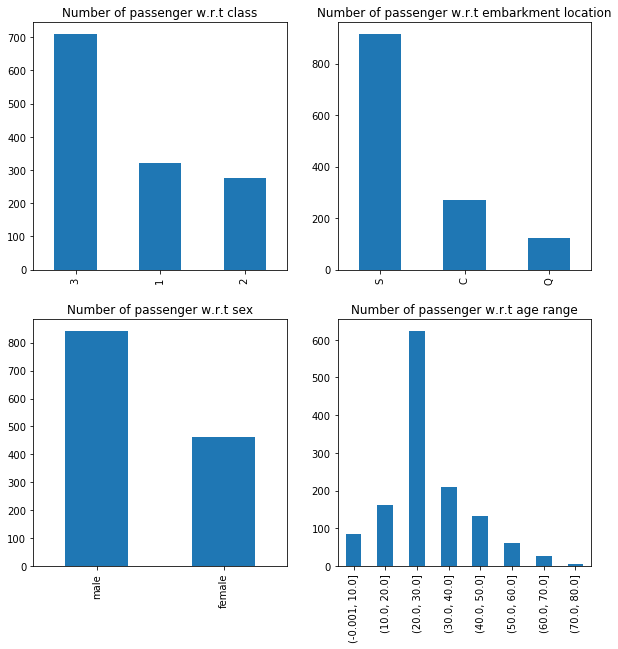

In [22]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(2, 2, figsize=(10,10))

data_titanic['pclass'].value_counts().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Number of passenger w.r.t class')

data_titanic['embarked'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Number of passenger w.r.t embarkment location')

data_titanic['sex'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Number of passenger w.r.t sex')

age_binned = pd.cut(data_titanic['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], include_lowest=True)
axes[1, 1].set_title('Number of passenger w.r.t age range')
age_binned.value_counts(sort=False).plot(kind='bar', ax=axes[1, 1])

plt.show()

**Comments:** We clearly see that most people were in the third class (~50%), and then almost equally splitted between the first and second class.

The age plot indicates a huge discrepancy between male and female people present on the boat.
On a side note, we can clearly see on the age plot that the imputed values for the NaN impacts the histogram by representing widely the median range, 20-30 range.

---
## 3.

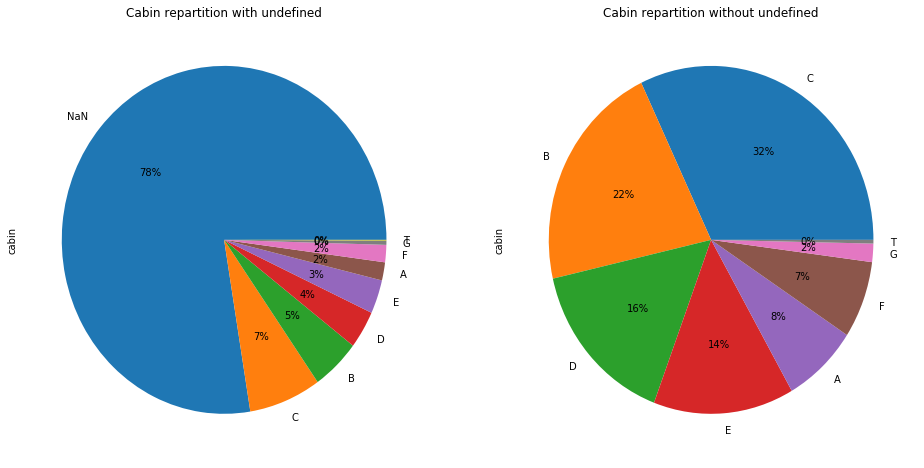

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

s = data_titanic['cabin']
s_nan = s.astype(str).str[0]
# We have to replace the N
s_nan = s_nan.replace('n', 'NaN')
s_no_nan = s.dropna().astype(str).str[0]

axes[0].set_title('Cabin repartition with undefined')
s_nan.value_counts().plot.pie(ax=axes[0], autopct='%1.0f%%')
axes[1].set_title('Cabin repartition without undefined')
s_no_nan.value_counts().plot.pie(ax=axes[1], autopct='%1.0f%%')
plt.show()

---
## 4.

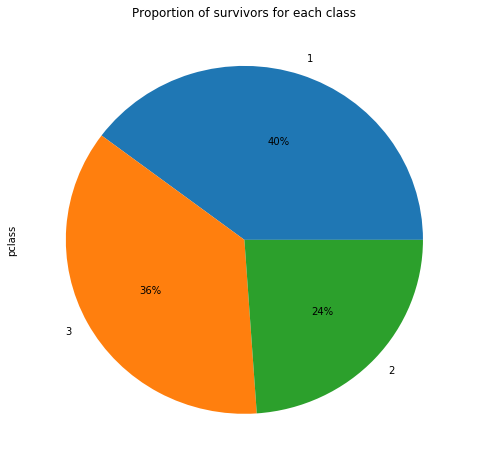

In [24]:
plt.figure(figsize=(8,8))
df = data_titanic[data_titanic['survived'] == 1]['pclass']
df.value_counts().plot.pie(autopct='%1.0f%%')
plt.title('Proportion of survivors for each class')
plt.show()

**Comments:** As expected, most of the people who survived were from the upper-class, the first one, even in the presence of such a huge class imbalance.

An important thing to notice is that such a plot can be misleading, since the over-representation of the third class in the dataset could lead one to think that third-class people had a highest survival rate.
In fact, in-depth analysis in the point 6. will clearly prove the opposite and show a meaningful interpretation of the survival rate for each class.

## 5.

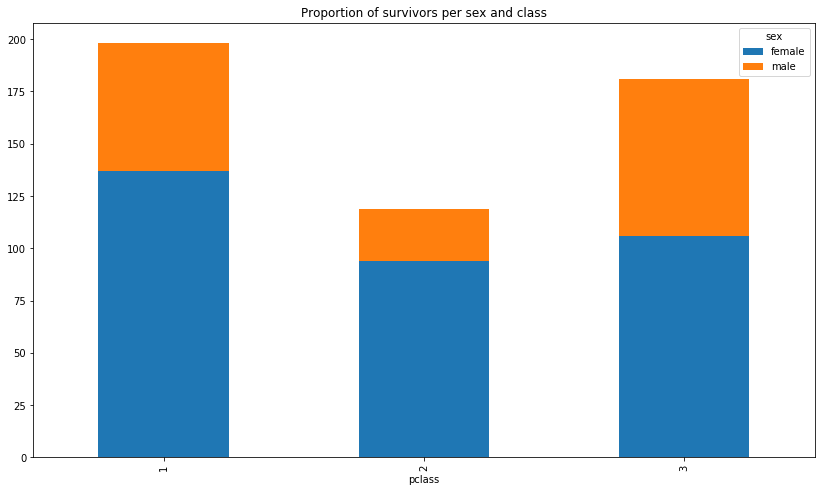

In [25]:
df = data_titanic[data_titanic['survived'] == 1]
df = df.groupby(['pclass', 'sex']).size().unstack()
df.plot.bar(stacked=True, figsize=(14,8))
plt.title('Proportion of survivors per sex and class')
plt.show()

**Comments:** Same as the previous plot, the over-representation of the sex "male" in the dataset can be misleading and one has to be careful about the conclusion drawn from such plots.
Once again, the survival **rate** for each group will be further analyzed in the next section.

---
## 6.

**Comments:** This section demonstrate the importance of *data interpretation* and how plots can lead to incorrect conclusions when not interpreted with caution.

Indeed, by analyzing survival rate group by group and not merged, we contradict all the potential conclusions from the previous sections. To counteract this phenomena (class imbalance), we could also have resampled the classes equally before doing the previous plots.

In [26]:
df = data_titanic[['age', 'pclass', 'sex', 'survived']]
df = df.sort_values('age')
# Take the 50% quantile (quantile) of the indices (since the median by age) will not produce two equally sized sets.
# The result will satisfy the conditions answered for the question 20) in the FAQ
# CAREFUL: df must be sorted by age before taking such a median by indices.
med_id = df.shape[0] // 2
print('Age of the median:', int(df.iloc[med_id]['age']), 'years old')

df['age_group'] = 'Older'
df.iloc[:med_id]['age_group'] = 'Younger'

df['age_group'] = df['age_group'].astype('category')
df['survived'] = df['survived'].astype(bool)

groups = pd.DataFrame(df.groupby(['age_group', 'pclass', 'sex', 'survived']).size())
# Following the instructions:  Present your results in a DataFrame with unique index.
groups.reset_index(inplace=True) 
groups.columns = ['age category', 'class', 'sex', 'survived', 'count']

groups

Age of the median: 28 years old


,age category,class,sex,survived,count
0,Older,1,female,False,3
1,Older,1,female,True,96
2,Older,1,male,False,91
3,Older,1,male,True,37
4,Older,2,female,False,7
5,Older,2,female,True,47
6,Older,2,male,False,92
7,Older,2,male,True,8
8,Older,3,female,False,39
9,Older,3,female,True,40


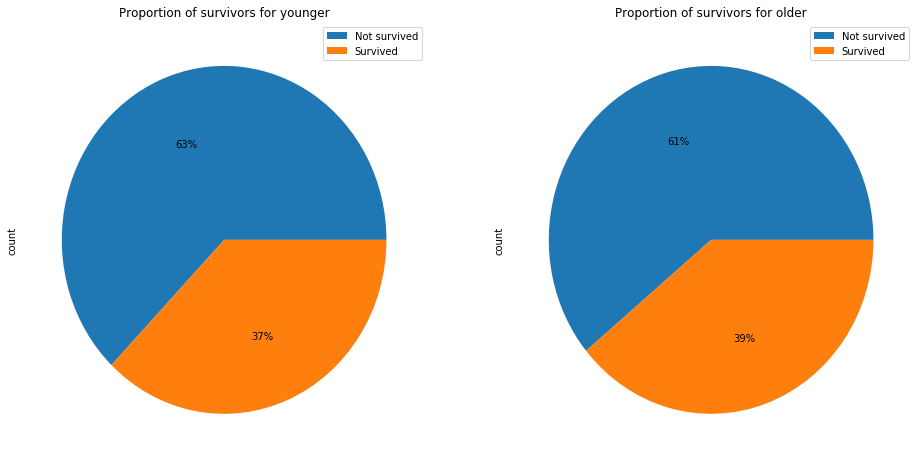

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
groups[groups['age category'] == 'Younger'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[0], labels=['', ''])
groups[groups['age category'] == 'Older'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[1], labels=['', ''])
axes[0].set_title('Proportion of survivors for younger')
axes[1].set_title('Proportion of survivors for older')
axes[0].legend(labels=['Not survived', 'Survived'])
axes[1].legend(labels=['Not survived', 'Survived'])
plt.show()

We don't see any clear difference between the two groups in term of survival rate.

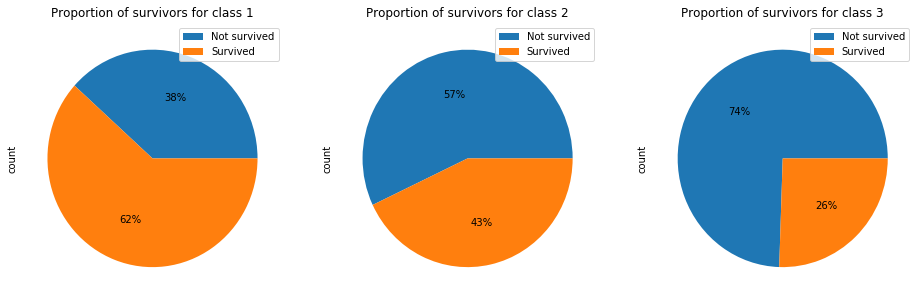

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
groups[groups['class'] == 1].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[0], labels=['', ''])
groups[groups['class'] == 2].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[1], labels=['', ''])
groups[groups['class'] == 3].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[2], labels=['', ''])
axes[0].set_title('Proportion of survivors for class 1')
axes[1].set_title('Proportion of survivors for class 2')
axes[2].set_title('Proportion of survivors for class 3')
axes[0].legend(labels=['Not survived', 'Survived'])
axes[1].legend(labels=['Not survived', 'Survived'])
axes[2].legend(labels=['Not survived', 'Survived'])
plt.show()

We can clearly notice that the survival rate decreases drastically as the class changes from first to "ecnonomy" class.

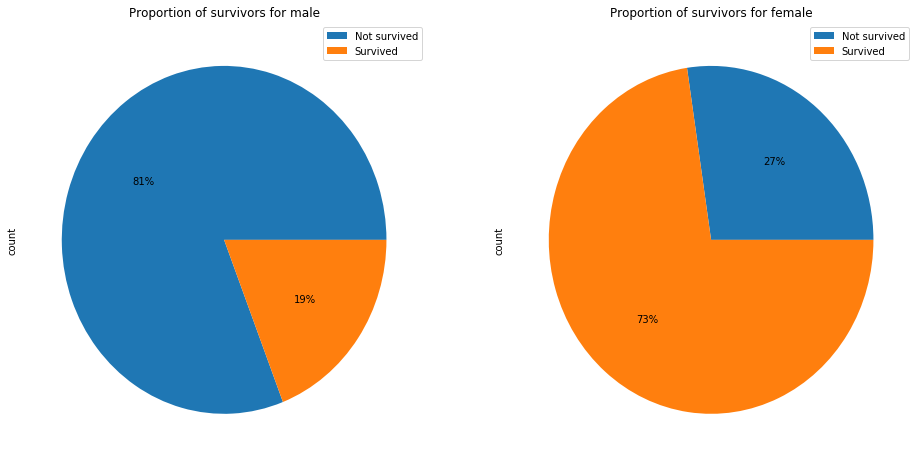

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
groups[groups['sex'] == 'male'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[0], labels=['', ''])
groups[groups['sex'] == 'female'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[1], labels=['', ''])
axes[0].set_title('Proportion of survivors for male')
axes[1].set_title('Proportion of survivors for female')
axes[0].legend(labels=['Not survived', 'Survived'])
axes[1].legend(labels=['Not survived', 'Survived'])
plt.show()

We notice a huge difference in the survival rate between genders. Indeed, women have a much higher survival rate than men.

### We then chose the 12.5% lower quantile to exacerbate the motto "Women and children first"    (:

In [30]:
df = data_titanic[['age', 'pclass', 'sex', 'survived']]
df = df.sort_values('age')
# Take the 12.5% quantile (quantile) of the indices (since the median by age) will not produce two equally sized sets.
# The result will satisfy the conditions answered for the question 20) in the FAQ
# CAREFUL: df must be sorted by age before taking such a median by indices.
med_id = df.shape[0] // 8
print('Age of the median:', int(df.iloc[med_id]['age']), 'years old')

df['age_group'] = 'Older'
df.iloc[:med_id]['age_group'] = 'Younger'

df['age_group'] = df['age_group'].astype('category')
df['survived'] = df['survived'].astype(bool)

groups = pd.DataFrame(df.groupby(['age_group', 'pclass', 'sex', 'survived']).size())
# Following the instructions:  Present your results in a DataFrame with unique index.
groups.reset_index(inplace=True) 
groups.columns = ['age category', 'class', 'sex', 'survived', 'count']

Age of the median: 18 years old


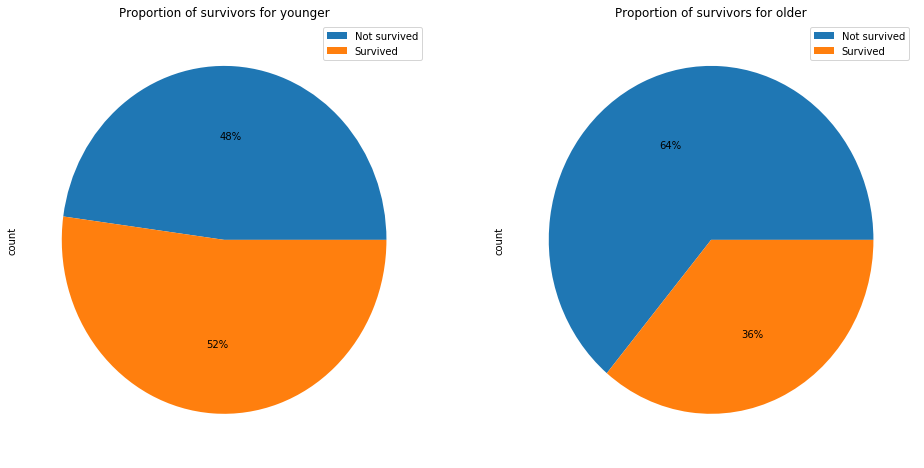

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
groups[groups['age category'] == 'Younger'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[0], labels=['', ''])
groups[groups['age category'] == 'Older'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[1], labels=['', ''])
axes[0].set_title('Proportion of survivors for younger')
axes[1].set_title('Proportion of survivors for older')
axes[0].legend(labels=['Not survived', 'Survived'])
axes[1].legend(labels=['Not survived', 'Survived'])
plt.show()

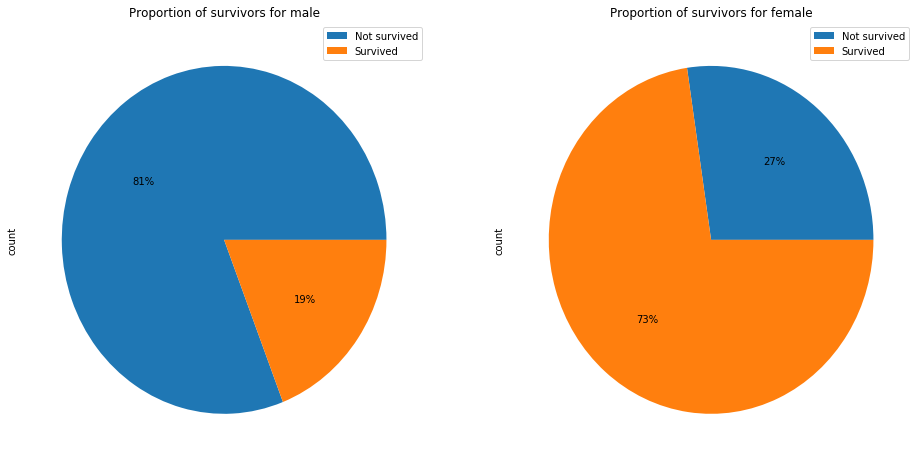

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
groups[groups['sex'] == 'male'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[0], labels=['', ''])
groups[groups['sex'] == 'female'].groupby('survived').sum().plot.pie(y='count', autopct='%1.0f%%', ax=axes[1], labels=['', ''])
axes[0].set_title('Proportion of survivors for male')
axes[1].set_title('Proportion of survivors for female')
axes[0].legend(labels=['Not survived', 'Survived'])
axes[1].legend(labels=['Not survived', 'Survived'])
plt.show()

### Here we clearly see the motto appearing as we lower the threshold to create the two sets.